## HouseKeeping

In [2]:
% load_ext autoreload
% autoreload 2
import pandas as pd
from BioAnalysis import BioAnalysis
import numpy as np
from tqdm import tqdm, trange
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import operator 
from collections import OrderedDict
from sklearn.linear_model import RANSACRegressor
from scipy.stats import fisher_exact
from IPython.display import HTML, display
import csv
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
db = pd.read_csv('../Amrita_5feb/features.csv')
# lets subtract the bgmean from the intensity

columns = list(db.columns)

# intensities = [s for s in columns if "Intensity_MC" in s]
# bkgds = [s for s in columns if "Bkgd" in s]

# for a,b in zip(intensities, bkgds):  
#     db[a] = db[a] - db[b]
    
analysis = BioAnalysis('../Amrita_5feb/')
points = analysis.points


filtered = analysis.getFilteredIndices()

filtered_db = pd.DataFrame(columns=db.columns)
for idx,row in enumerate(tqdm(filtered)):
    filtered_db = filtered_db.append(db[(db.Class == int(row[0])) & (db["Object Number"]==int(row[1]))])
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch02')] = points[idx, 0]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch07')] = points[idx, 1]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch11')] = points[idx, 2]
    try:
        filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch04')] = points[idx, 3]
    except:
        pass

100%|██████████| 7143/7143 [00:21<00:00, 326.82it/s]


In [7]:
filtered_db = filtered_db.loc[:,~filtered_db.columns.duplicated()]
data = []
data.append('Class')
data.append('Object Number')
data.append('Area_M01')
data.append('Area_M02')
data.append('Area_M03')
data.append('Area_M06')
data.append('Area_M07')
data.append('Area_M09')
data.append('Area_M11')
data.append('Aspect Ratio_M01')
data.append('Aspect Ratio_M06')
data.append('Aspect Ratio_M09')
data.append('Modulation_M02_Ch02')
data.append('Modulation_M03_Ch03')
data.append('Modulation_M07_Ch07')
data.append('Modulation_M11_Ch11')
data.append('Intensity_MC_Ch02')
data.append('Intensity_MC_Ch07')
data.append('Intensity_MC_Ch11')
data
filtered_db = filtered_db[data]
#     if idx%100==0:
#         sys.stdout.write(str(idx) + '\r')
#         sys.stdout.flush()
print([column for column in filtered_db.columns])

['Class', 'Object Number', 'Area_M01', 'Area_M02', 'Area_M03', 'Area_M06', 'Area_M07', 'Area_M09', 'Area_M11', 'Aspect Ratio_M01', 'Aspect Ratio_M06', 'Aspect Ratio_M09', 'Modulation_M02_Ch02', 'Modulation_M03_Ch03', 'Modulation_M07_Ch07', 'Modulation_M11_Ch11', 'Intensity_MC_Ch02', 'Intensity_MC_Ch07', 'Intensity_MC_Ch11']


## What features can predict age (with and without ch1,6,9)?

### With Ch 1, 6, 9

Feature Importances:
Intensity_MC_Ch02 0.111
Intensity_MC_Ch07 0.101
Intensity_MC_Ch11 0.097
Aspect Ratio_M06 0.076
Area_M03 0.075
Aspect Ratio_M01 0.073
Modulation_M03_Ch03 0.069
Area_M06 0.068
Aspect Ratio_M09 0.067
Area_M09 0.066
Cross-validation Score: 0.604793274422


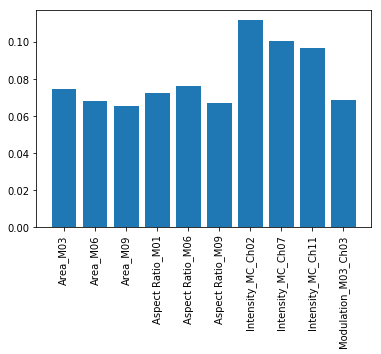

In [8]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()


### Without Ch 1, 6, 9

Feature Importances:
Intensity_MC_Ch11 0.179
Intensity_MC_Ch02 0.167
Intensity_MC_Ch07 0.162
Modulation_M03_Ch03 0.146
Area_M03 0.129
Area_M02 0.088
Modulation_M02_Ch02 0.086
Area_M07 0.015
Modulation_M11_Ch11 0.010
Modulation_M07_Ch07 0.010
Cross-validation Score: 0.624942868994


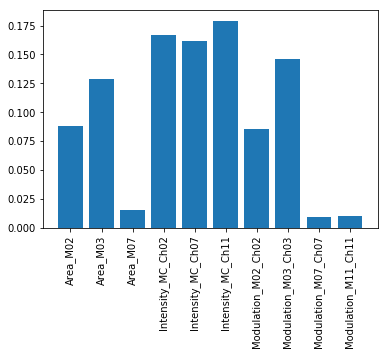

In [9]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()


## What features predict ch11 Klotho?

Feature Importances:
Modulation_M07_Ch07 0.750
Intensity_MC_Ch07 0.270
Intensity_MC_Ch02 0.164
Area_M07 0.120
Area_M06 0.082
Area_M09 0.043
Area_M03 0.041
Area_M02 0.029
Modulation_M02_Ch02 0.024
Aspect Ratio_M01 0.017
Cross-validation Score: -5.30005573179
Cross-validation Score Var: 0.521054993074


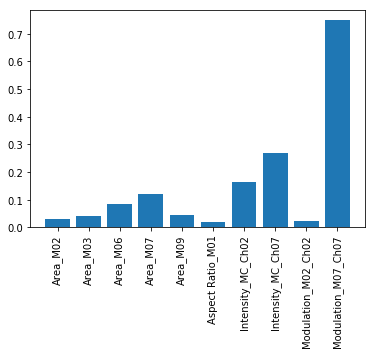

In [10]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Intensity_MC_Ch11.to_numpy()
# Y = Y>0 # ch11> = 1, ch11< = 0
# print(np.count_nonzero(Y))
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "Aspect Ratio_M02" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
# X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
reg = LinearRegression()
sol = reg.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

## Correlation between ch7 and ch11. 

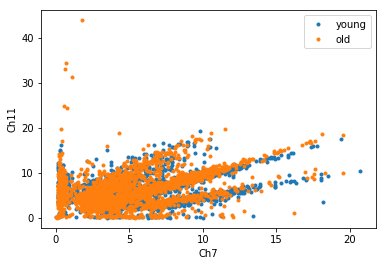

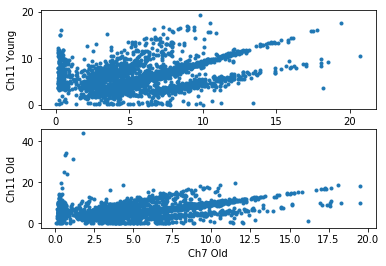

Young Pearson's correlation coefficient
[[ 1.          0.34265512]
 [ 0.34265512  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.39994408]
 [ 0.39994408  1.        ]]


In [12]:
new_db = filtered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.legend(['young', 'old'])
plt.xlabel('Ch7')
plt.ylabel('Ch11')
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch11 Old')
# plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch11_intensity))


### Let's try and run ransac on this example

  0%|          | 0/300 [00:00<?, ?it/s]

('took iterations:', 1, 'best model:', array([ -6.09577298e-01,   7.92726620e-01,  -1.51689453e-04]), 'explains:', 3491)


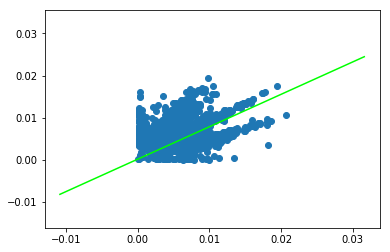

slope:1.30045299066


In [13]:
from ransac import *
X = young_ch7_intensity.to_numpy()/1000.0
Y = young_ch11_intensity.to_numpy()/1000.0
while X.shape[0]>20:
    inliers,model = ransac(X,Y)
    a,b,c = model
    print('slope:' + str(-b/a))
    X = X[inliers.flatten()<=0]
    Y = Y[inliers.flatten()<=0]
    if X.shape[0] <20:
        continue


In [ ]:
print(X.shape)

X = X[inliers.flatten()>0,...]
X.shape

## Correlation between ch2 and ch11. 

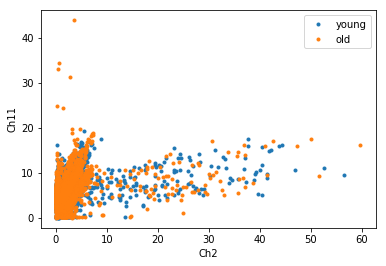

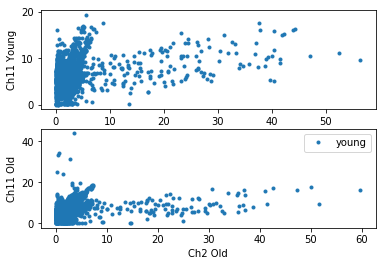

Young Pearson's correlation coefficient
[[ 1.          0.33301404]
 [ 0.33301404  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.29402601]
 [ 0.29402601  1.        ]]


In [15]:
new_db = filtered_db
plt.figure()
young_ch2_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch2_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2')
plt.ylabel('Ch11')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch2 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2 Old')
plt.ylabel('Ch11 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch2_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch2_intensity, old_ch11_intensity))

## Differences in cd81, cd63 between young and old. 
Generated using code written by Ankit

In [16]:
analysis.getContingencyMatrix()

('Number of Young samples:', 3491)
('Number of Old Samples:', 3652)


,Young,Old
CD63+,3466.0,3608.0
CD63-,25.0,44.0


('p-value:', 0.039352785652233518)


,Young,Old
CD81+,1316.0,1416.0
CD81-,2175.0,2236.0


('p-value:', 0.35481172537058647)


,Young,Old
CD9+,256.0,402.0
CD9-,3235.0,3250.0


('p-value:', 7.6657506877506022e-08)


Old
Intensity CD63
Mean: 2.80 Variance: 16.83
Intensity CD81
Mean: 5.50 Variance: 8.14
Intensity KL
Mean: 6.08 Variance: 9.37
Size CD63
Mean: 411.95 Variance: 79345.51
Size CD81
Mean: 365.80 Variance: 45585.92
Size KL
Mean: 378.22 Variance: 45325.68
Young
Intensity CD63
Mean: 2.82 Variance: 23.36
Intensity CD81
Mean: 5.93 Variance: 8.92
Intensity KL
Mean: 5.92 Variance: 6.99
Size CD63
Mean: 305.38 Variance: 64962.07
Size CD81
Mean: 377.29 Variance: 37818.07
Size KL
Mean: 381.07 Variance: 33851.93


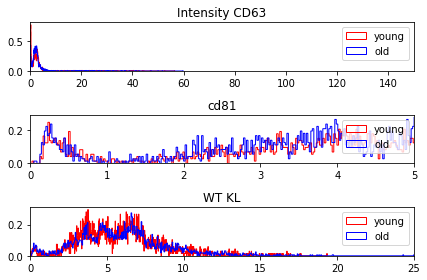

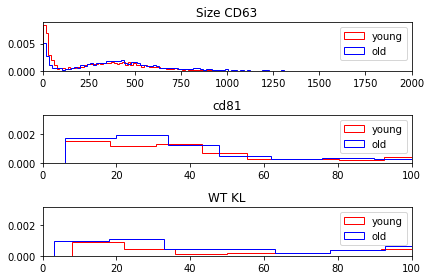

In [17]:
hist_range = [[0,150],[0,5],[0,25],[0,2000],[0,100],[0,100]]
# hist_range = []
dist = analysis.getTotalIntensityDistribution(hist_range)

labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Size CD63', 'Size CD81', 'Size KL']
for key in dist:
    print (key)
    for i,label in enumerate(labels):
        print(label)
        print('Mean: {0:.2f} Variance: {1:.2f}'.format(dist[key]['Mean'][i],dist[key]['Var'][i]))

In [18]:
points_young = analysis.points_young
points_old = analysis.points_old

from scipy.stats import mannwhitneyu
print ('Mann Whitney U Test Resuts:')
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Size CD63', 'Size CD81', 'Size KL']
for i in range(0,6):
    young = points_young[:,i]
    old = points_old[:,i]
    print(labels[i] + ': ' +  str(mannwhitneyu(young, old)[1]))


Mann Whitney U Test Resuts:
Intensity CD63: 1.067397534e-07
Intensity CD81: 4.3746925708e-12
Intensity KL: 0.0437684950384
Size CD63: 1.05206858764e-53
Size CD81: 3.6262659473e-06
Size KL: 0.00126367783382


## What happens if we keep all background mean features:

Feature Importances:
Intensity_MC_Ch02 0.110
Intensity_MC_Ch11 0.097
Intensity_MC_Ch07 0.096
Area_M06 0.075
Area_M09 0.073
Aspect Ratio_M06 0.073
Modulation_M03_Ch03 0.071
Aspect Ratio_M09 0.068
Area_M03 0.068
Aspect Ratio_M01 0.068
Cross-validation Score: 0.606441218757


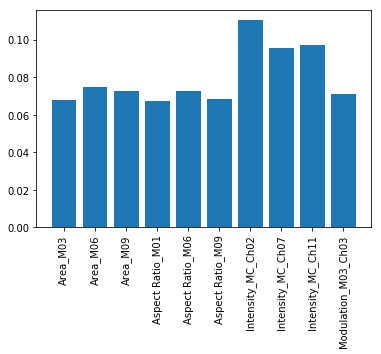

In [19]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # ch04> = 1, ch04< = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)


#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

## Is there a way to find out if most of ch11 is >0 in cells that are ch2<0 and ch7>0

In [20]:
new_db = filtered_db
new_db = new_db[(new_db.Intensity_MC_Ch02 <0) & (new_db.Intensity_MC_Ch07>0)]
print('So what are we left with:', str(new_db.shape))
ch11 = new_db.Intensity_MC_Ch11
print('Ch11 positive:', np.count_nonzero(ch11>0))
print('Ch11 negative:', np.count_nonzero(ch11<=0))

('So what are we left with:', '(0, 19)')
('Ch11 positive:', 0)
('Ch11 negative:', 0)


## Using your method...if we do correlation between cd63 and KL or cd81 and KL.  Do we see the same thing?
### CD81 & KL

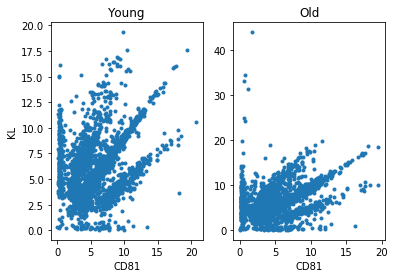

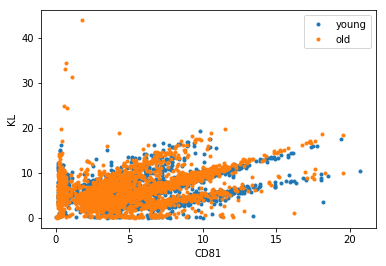

In [21]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.figure()
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')
plt.legend(['young', 'old'])
plt.show()

### CD63 and KL

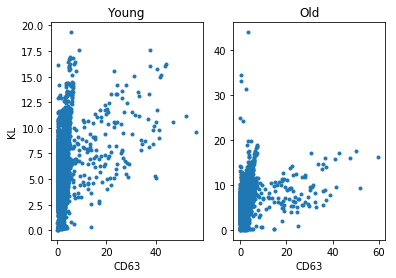

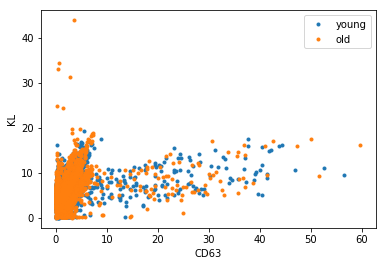

In [22]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.figure()
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')
plt.legend(['young', 'old'])